# 개체명 인식을 위한 양방향 LSTM 모델
**챗봇 엔진에 개체명 인식(named entity Recognition)을 위해 사용하는 양방향 LSTM(Bi-LSTM). LSTM은 순환 싱경망 모델의 일종으로 시퀀스 또는 시계열 데이터의 패턴을 인식하는 분야에서 많이 사용한다. **연속적인 데이터의 패턴을 이용해 결과를 예측하므로 주로 주가 예측이나 신호 분석 및 번역 분야에서 좋은 성능을 보여준다.

## RNN
LSTM은 RNN 모델에서 파생되었다. RNN(Recurrent Neural Network)은 순환 신견망으로 불리며, 앞서 배운 신경망 모델과 다르게 은닉층 노드의 출력값과 그 다음 시점의 은닉충의 입력으로 전달해 순환하는 특징을 갖고 있다.



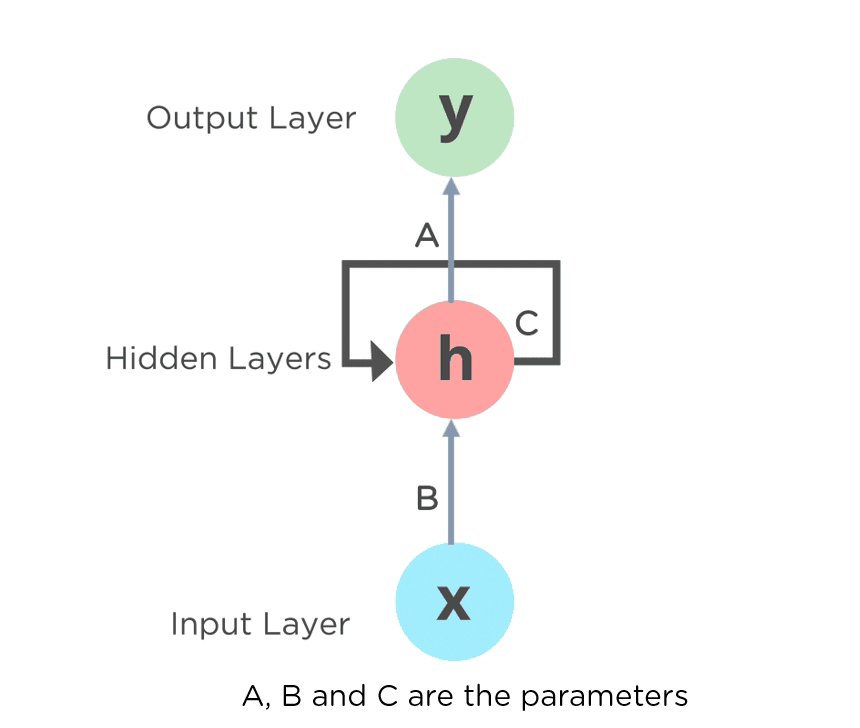

**RNN에서 은닉층 노드는 이전 시점 (t-1)의 상탯값을 저장하는 메모리 역할을 수행하기 때문에 셀(cell) 또는 메모리 셀이라고 부른다. 은닉층의 메모리 셀의 출력 벡터는 출력층과 다음 시점(t+1)의 메모리 셀에 전달되는데 이를 은닉 상태(hidden state)라고 한다.**

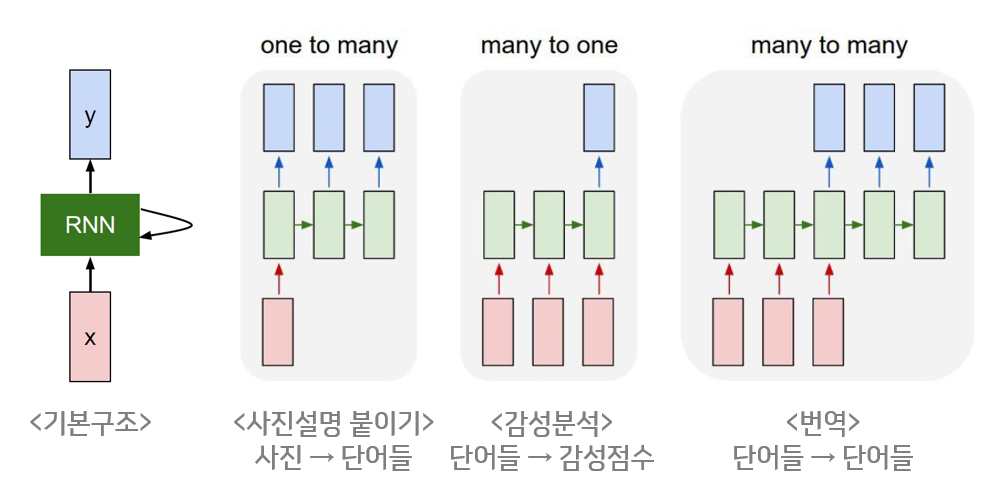

one-to-many 구조는 보통 한 장의 이미지를 입력받아 이미지를 설명하는 텍스트를 출력하는 모델로 사용할 수 있다. many-to-one 모델은 메일 제목을 입력받아 해당 메일이 스팸인지 아닌지 판단할 수 있는 모델로도 사용할 수 있다. many-to-many 모델은 개체명 인식기로 사용되며, 단어 시퀀스를 입력받아 각 시퀀스가 의미하는 개체명을 출력하는 구조다. 또한 한국어를 입력받아 영어로 출력하는 번역기 모델로도 사용이 가능하다.

다음은 RNN 모델에서 수식 계산에 필요한 입출력 및 가중치 파라미터의 관계와 위치를 보여준다. 참고로 RNN은 모든 시점에서 동일한 가중치와 편향값을 사용한다.

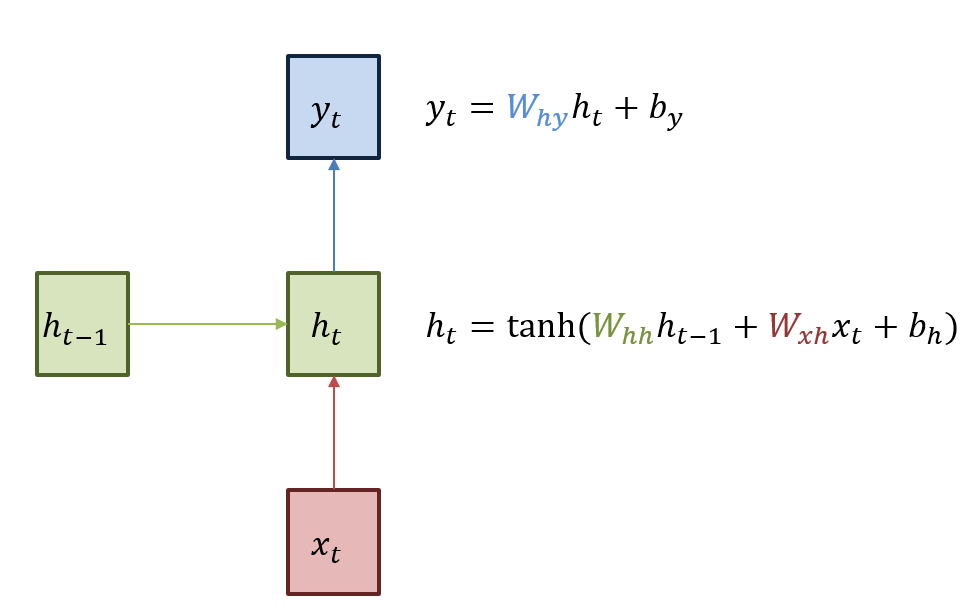

## RNN 모델의 동작 방식
현재 시점을 t로 정의했을 때, **Xi는 현재 시점의 입력 벡터, yt는 현재 시점의 출력 벡터, ht는 현재 시점의 은닉 상태 벡터값**을 의미한다. 다른 신경망과 마찬가지로 RNN에서도 각 노드와 연결되어 잇는 가중치가 존재한다. **Wx는 입력 Xt에 대한 가중치, Wh는 이전 시점의 은닉 상태값인 ht-1에 대한 가중치, Wy는 현재 시점의 은닉 상탯값인 ht에 대한 가중치 이다.**

활성화 함수는 하이퍼블릭 탄젠트(tanh)를 사용하며, 이때 이전 시점의 은닉 상탯값이 현재 시점의 은닉 상태에 계속해서 영향을 주기 때문에 시퀀스 데이터의 특징을 잘 파악할 수 있다. 마지막으로 출력층 yt는 메모리 셀에서 계산된 은닉 상탯값 ht와 가중치 Wy를 곱한 값으로 계산한다.

다음은 특정 범위 만큼의 sin 파형 시퀀스를 학습해 다음 스텝의 파형을 예측하는 RNN 모델을 구현해보면서 케라스에서 어떻게 RNN 계층을 사용하는지 알아본다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LSTM, SimpleRNN

In [3]:
# time step만큼 시퀀스 데이터 분리
def split_sequence(sequence, step):
  x, y = list(), list() # 입력 인자로 넘어온 리스트 데이터를 

  for i in range(len(sequence)): #순차적으로 step 크기만큼 나눠 RNN 모델에 사용될
    end_idx = i+step
    if end_idx > len(sequence)-1:
      break

    seq_x, seq_y = sequence[i:end_idx], sequence[end_idx] # 시퀀스 (x)와 출력값(y)을 넘파이 배열로 만든다.
    x.append(seq_x)
    y.append(seq_y)

  return np.array(x), np.array(y)

In [4]:
# sin 함수 학습 데이터
# -10에서 +10 사이의 x축 범위를 가지는 sin() 함수 값을 0.1 단위로 증가시켜 train_y 리스트에 저장한다.
# train_y 리스트는 RNN 모델 학습에 필요한 학습 데이터셋이다.
x = [i for i in np.arange(start=-10, stop=10, step=0.1)] 
train_y = [np.sin(i) for i in x]

In [5]:
# 하이퍼 파라미터
n_timesteps = 15 #입력 시퀀스 길이를 15로 정의한다. 이 때, 15만큼 RNN 메모리 셀이 생성된다.
n_features = 1 # 입력 벡터의 차원크기는 1로 정의한다.

In [6]:
# 시퀀스 나누기
# train_x.shape => (samples, timesteps)
# train_y.shape => (samples)

train_x, train_y = split_sequence(train_y, step=n_timesteps) # sin 파형의 학습 데이터가 들어 있는 train_y 리스트에서 n_timesteps만큼 나눠서 입력 시퀀스를 생성한다.
print("shape x : {}".format(train_x.shape, train_y.shape))

shape x : (185, 15)


In [7]:
# RNN 입력 벡터 크기를 맞추기 위해 벡터 차원 크기 변경
# reshape from [samples, timesteps] into [sample, timesteps, features]

# Keras에서 RNN 계층을 사용하려면 3차원 텐서(Tensor) 형태여야 한다. 따라서 현재 2차원 (samples, time step)인 train_x를 RNN 모델의 입력 데이터 형상에 맞게 3차원 (batch size, time step, input length) 형태로 변환한다.
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], n_features)
print("train_x.shape = {}".format(train_x.shape))
print("train_y.shape = {}".format(train_y.shape))

train_x.shape = (185, 15, 1)
train_y.shape = (185,)


In [8]:
# RNN 모델 정의
model = Sequential()
model.add(SimpleRNN(units=10, # units는 RNN 계층에 존재하는 전체 뉴런 수이다.
                    return_sequences=False, # return_sequences는 앞서 배운 RNN 계산 과정에서 은닉 상탯값을 출력할지 결정한다. False인 경우 마지막 시점의 메모리 셀에서만 결과를 출력한다.
                    # True인 경우 모든 RNN 계산 과정에서 결과를 출력한다. ->출력이 여러 개인 one-to-many, many-to-many 구조를 위해 사용한다.
                    input_shape=(n_timesteps, n_features))) # RNN 모델의 입력 데이터 형상(shape)을 정의한다.
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [9]:
# 모델 학습
np.random.seed(0)

# Overfitting을 피하기 위해 손실(loss)이 갑자기 증가되는 시점을 찾을 수 있는 조기 종료(EarlyStopping) 콜백 객체를 사용한다.
from tensorflow.keras.callbacks import EarlyStopping
early_stopping= EarlyStopping(
    monitor='loss',
    patience=5, # 성능이 증가하지 않을 때 5 epoch 정도 더 학습하도록 설정한다.
    mode='auto'
)
history = model.fit(train_x, train_y, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000
6/6 [==============================] - 4s 13ms/step - loss: 0.3068
Epoch 2/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1923
Epoch 3/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.1195
Epoch 4/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.0789
Epoch 5/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0567
Epoch 6/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0482
Epoch 7/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0435
Epoch 8/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0403
Epoch 9/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0373
Epoch 10/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0341
Epoch 11/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.0312
Epoch 12/1000
6/6 [==============================] - 0s 20ms/step - loss: 0.0284
Epoch 13/1000
6/6 [==================

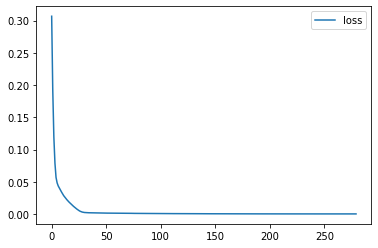

In [10]:
# loss 그래프 생성
plt.plot(history.history['loss'], label="loss")
plt.legend(loc="upper right")
plt.show()

In [11]:
# 테스트 데이터셋 생성
test_x = np.arange(10, 20, 0.1) 
calc_y = np.cos(test_x) # 10 ~ 20 사이의 x축 범위를 가지는 cos 함수를 값을 0.1 단위로 증가시켜 calc_y 리스트에 저장한다.

In [12]:
# RNN 모델 예측 및 로그 저장
test_y = calc_y[:n_timesteps]
for i in range(len(test_x) - n_timesteps):
  net_input = test_y[i : i+n_timesteps]
  net_input = net_input.reshape((1,n_timesteps, n_features))
  train_y = model.predict(net_input, verbose=0)
  print(test_y.shape, train_y.shape, i, i+n_timesteps)
  test_y=np.append(test_y, train_y)

(15,) (1, 1) 0 15
(16,) (1, 1) 1 16
(17,) (1, 1) 2 17
(18,) (1, 1) 3 18
(19,) (1, 1) 4 19
(20,) (1, 1) 5 20
(21,) (1, 1) 6 21
(22,) (1, 1) 7 22
(23,) (1, 1) 8 23
(24,) (1, 1) 9 24
(25,) (1, 1) 10 25
(26,) (1, 1) 11 26
(27,) (1, 1) 12 27
(28,) (1, 1) 13 28
(29,) (1, 1) 14 29
(30,) (1, 1) 15 30
(31,) (1, 1) 16 31
(32,) (1, 1) 17 32
(33,) (1, 1) 18 33
(34,) (1, 1) 19 34
(35,) (1, 1) 20 35
(36,) (1, 1) 21 36
(37,) (1, 1) 22 37
(38,) (1, 1) 23 38
(39,) (1, 1) 24 39
(40,) (1, 1) 25 40
(41,) (1, 1) 26 41
(42,) (1, 1) 27 42
(43,) (1, 1) 28 43
(44,) (1, 1) 29 44
(45,) (1, 1) 30 45
(46,) (1, 1) 31 46
(47,) (1, 1) 32 47
(48,) (1, 1) 33 48
(49,) (1, 1) 34 49
(50,) (1, 1) 35 50
(51,) (1, 1) 36 51
(52,) (1, 1) 37 52
(53,) (1, 1) 38 53
(54,) (1, 1) 39 54
(55,) (1, 1) 40 55
(56,) (1, 1) 41 56
(57,) (1, 1) 42 57
(58,) (1, 1) 43 58
(59,) (1, 1) 44 59
(60,) (1, 1) 45 60
(61,) (1, 1) 46 61
(62,) (1, 1) 47 62
(63,) (1, 1) 48 63
(64,) (1, 1) 49 64
(65,) (1, 1) 50 65
(66,) (1, 1) 51 66
(67,) (1, 1) 52 67
(68

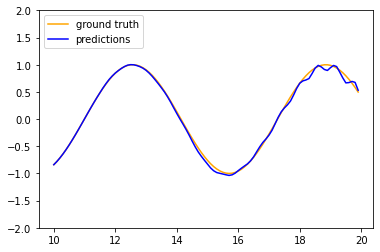

In [13]:
# 예측 결과 그래프 그리기
plt.plot(test_x, calc_y, label="ground truth", color="orange")
plt.plot(test_x, test_y, label="predictions", color="blue")

plt.legend(loc='upper left')
plt.ylim(-2, 2)
plt.show()

**입력 시퀀스의 시점(time step_이 길어질수록 앞쪽의 데이터가 뒤쪽으로 잘 전달되지 않아 학습 능력이 떨어진다. RNN을 다층 구조로 쌓으면 입력과 출력 데이터 사이의 연관 관계가 줄어들어 장기 의존성 (Long-Term Dependency) 문제가 생긴다.**